# Load, parse and split data

In [2]:
import pandas as pd
import numpy as np
from training.predictionAlgo import naiveNextEventPredictor, naiveTimeToNextEventPredictor
from preprocessing.dataParsing import parseData
from preprocessing.dataSplitting import dataSplitter
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from math import ceil

# Convert csv into dataframe
df_training_raw = pd.read_csv('.\data\BPI2012Training.csv')
df_test_raw = pd.read_csv('.\data\BPI2012Test.csv')

# Parsing data
(df_training, df_2012_last_event_per_case_train) = parseData(df_training_raw)
(df_test, df_2012_last_event_per_case_test) = parseData(df_test_raw)

# Clean and split the data into train, validation & test data
(df_training, df_validation, df_test) = dataSplitter(df_training, df_test)

Using TensorFlow backend.


# Prepare input of lstm for event prediction

In [63]:
def eventInputLstm(df, core_features: list, extra_features: list, scaler_encoder: list, window_size: int):
    '''
    args:
    df <class: 'pd.DataFrame'>: Dataframe of interest, filled with the features of arguments.
    core_features <class: 'list'>: Column names of the core features in format of [case id, current event, next event].
    extra_features <class: 'list'>: Extra features that the user wishes to train on, can be given in any sequences.
    scaler_encoder <class: 'list' of 'sklearn.preprocessing.MinMaxScaler' or klearn.preprocessing.OneHotEncoder>: 
    Trained scaler or encoder associated with the input features by their index that is used to normalise float or int features and encode categorical features.
    window_size <class: 'int'>: Window size of lstm input.
    
    returns:
    x_arr <'np.array'>: LSTM input in format [samples, timestep, features].
    y_arr <'np.array'>: LSTM input in format [samples, features].
    '''
    case_id_col = core_features[0]
    event_id_col = core_features[1]
    y_output_col = core_features[2]
    
    scaler_encoder_copy = scaler_encoder.copy()
    
    encoder_events = scaler_encoder_copy.pop(0)
    
    # Prevent modifying argument
    relevant_columns = core_features.copy()
    try:
        relevant_columns.extend(extra_features)
    except:
        print('Please input valid features.')
    
    df_relevant = df[relevant_columns].copy()

    # One-hot encode current and next event
    current_event = df_relevant[event_id_col].to_numpy().reshape(-1, 1)
    df_relevant[event_id_col] = encoder_events.transform(current_event).tolist()

    next_event = df_relevant[y_output_col].to_numpy().reshape(-1, 1)
    df_relevant[y_output_col] = encoder_events.transform(next_event).tolist()
    
    # Normalise extra features that are ints or floats
    for idx, scaler in enumerate(scaler_encoder_copy):
        if scaler != 0:
            to_be_normalised = df_relevant[extra_features[idx]].to_numpy().reshape(-1, 1)
            df_relevant[extra_features[idx]] = scaler.transform(to_be_normalised)

    # Prepare input and output in form of [samples, features]
    x = []
    y = []

    # Get groupby object df by case id
    df_groupby_case_id = df_relevant.groupby(case_id_col)

    # Unique case ids
    unique_case_ids = df_relevant[case_id_col].unique().tolist()

    # Find input and output vector in form of [samples, features]
    for unique_id in unique_case_ids:
        columns_relevant = [event_id_col, y_output_col].copy()
        columns_relevant.extend(extra_features)
        xy_unique_id = df_groupby_case_id.get_group(unique_id)[columns_relevant].values.tolist()
        sequence_x_unique_id = []

        # event[0] = current event, event[1] = next event, event[2] = first selected feature, event[3] = second selected feature,...
        for idx, event in enumerate(xy_unique_id):
            if len(sequence_x_unique_id) == window_size:
                del sequence_x_unique_id[0]

            event_memory = event[0].copy()
            event_memory.extend(event[2:])
            sequence_x_unique_id.append(event_memory.copy())
            x.append(sequence_x_unique_id.copy())
            y.append(event[1])
    
    # Alter input to [samples, timestep, features] for lstm, zero padding used to equalize timestep length
    x_arr = pad_sequences(x, dtype='float32')
    
    # Convert y to format [samples, features]
    y_arr = np.reshape(y, (-1, len(y[0])))

    return x_arr, y_arr

In [64]:
# Determine actual next event
(df_training, df_validation) = naiveNextEventPredictor(df_training, df_validation)
(df_training, df_test) = naiveNextEventPredictor(df_training, df_test)

current_unique = df_training['event concept:name'].unique()
next_unique = df_training['actual_next_event'].unique()
unique_training_events = np.append(next_unique, np.setdiff1d(current_unique, next_unique, assume_unique=True)).reshape(-1, 1)

# Define One-hot encoder for events
onehot_encoder_event = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder_event = onehot_encoder_event.fit(unique_training_events)

# see function comment for format
core_features = ['case concept:name', 'event concept:name', 'actual_next_event']

# Example with unix_reg_time as extra features
extra_features = ['event lifecycle:transition', 'case AMOUNT_REQ']

# now determining which feature of the extra features needs to be normalised becomes possible by inspecting the index of scalers list
encoder_scaler = [onehot_encoder_event] + [0]*len(extra_features)

# Instatiate scalers for features consisting out of the type float or int or encoder for categorical featurees
for idx, extra_feature in enumerate(extra_features):
    if len(df_training[extra_feature].unique()) < 25:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        arr_to_be_encoded = df_training[extra_feature].to_numpy().reshape(-1, 1)
        encoder = encoder.fit(arr_to_be_encoded)
        encoder_scaler[idx + 1] = encoder
    else:
        scaler = MinMaxScaler(feature_range=(0,1))
        arr_to_be_normalied = df_training[extra_feature].to_numpy().reshape(-1, 1)
        scaler = scaler.fit(arr_to_be_normalied)
        encoder_scaler[idx + 1] = scaler

# window size as the mean of case length
number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)

x_train, y_train = eventInputLstm(df_training, core_features, extra_features, encoder_scaler, number_events_mean)
x_val, y_val = eventInputLstm(df_validation, core_features, extra_features, encoder_scaler, number_events_mean)
x_test, y_test = eventInputLstm(df_test, core_features, extra_features, encoder_scaler, number_events_mean)

KeyboardInterrupt: 

# Prepare input of LSTM for time prediction

In [22]:
def timeInputLstm(df, core_features: list, extra_features: list, scaler_encoder: list, window_size: int):
    '''
    args:
    df <class: 'pd.DataFrame'>: Dataframe of interest, filled with the features of arguments.
    core_features <class: 'list'>: Column names of the core features in format of [case id, current event, time to next event].
    extra_features <class: 'list'>: Extra features that the user wishes to train on, can be given in any sequences.
    scaler_encoder <class: 'list' of 'sklearn.preprocessing.MinMaxScaler' or klearn.preprocessing.OneHotEncoder>: 
    Trained scaler or encoder associated with the input features by their index that is used to normalise float or int features and encode categorical features.
    window_size <class: 'int'>: Window size of lstm input.
    
    returns:
    x_arr <'np.array'>: LSTM input in format [samples, timestep, features].
    y_arr <'np.array'>: LSTM input in format [samples, features].
    '''
    # See function comment for format
    case_id_col = core_features[0]
    event_id_col = core_features[1]
    y_output_col = core_features[2]
    
    scaler_encoder_copy = scaler_encoder.copy()
    
    encoder_events = scaler_encoder_copy.pop(0)

    time_to_next_scaler = scaler_encoder_copy.pop(0)
    
    # Prevent modifying argument
    relevant_columns = core_features.copy()
    relevant_columns.extend(extra_features)
    
    try:
        df_relevant = df[relevant_columns].copy()
    except:
        print('Please input valid features.')

    # One-hot encode current event
    current_event = df_relevant[event_id_col].to_numpy().reshape(-1, 1)
    df_relevant[event_id_col] = encoder_events.transform(current_event).tolist()

    # Normalise time to next event.
    time_to_next_event = df_relevant[y_output_col].to_numpy().reshape(-1, 1)
    df_relevant[y_output_col] = time_to_next_scaler.transform(time_to_next_event)
    
    for idx, scaler_encoder in enumerate(scaler_encoder_copy):
            to_be_normalised_or_encoded = df_relevant[extra_features[idx]].to_numpy().reshape(-1, 1)
            df_relevant[extra_features[idx]] = scaler_encoder.transform(to_be_normalised_or_encoded)

    # Prepare input and output in form of [samples, features]
    x = []
    y = []

    # Get groupby object df by case id
    df_groupby_case_id = df_relevant.groupby(case_id_col)

    # Unique case ids
    unique_case_ids = df_relevant[case_id_col].unique().tolist()
    
    # Remove case id out of relevant columns
    del relevant_columns[0]

    # Find input and output vector in form of [samples, features]
    for unique_id in unique_case_ids:
        xy_unique_id = df_groupby_case_id.get_group(unique_id)[relevant_columns].values.tolist()
        sequence_x_unique_id = []

        # event[0] = current event, event[1] = actual time to next event, event[2] = first selected feature, event[3] = second selected feature,...
        for event in xy_unique_id:
            if len(sequence_x_unique_id) == number_events_mean:
                del sequence_x_unique_id[0]

            event_memory = event[0].copy()
            event_memory.extend(event[2:])
            sequence_x_unique_id.append(event_memory.copy())
            x.append(sequence_x_unique_id.copy())
            y.append(event[1])
    
    # Alter input to [samples, timestep, features] for lstm, zero padding used to equalize timestep length
    x_arr = pad_sequences(x, dtype='float32')
    
    # Convert y to format [samples, features]
    y_arr = np.reshape(y, (-1, 1))

    return x_arr, y_arr

In [35]:
# Determine time to next event
(df_training, df_validation) = naiveTimeToNextEventPredictor(df_training, df_validation)
(df_training, df_test) = naiveTimeToNextEventPredictor(df_training, df_test)

# Determine actual next event
(df_training, df_validation) = naiveNextEventPredictor(df_training, df_validation)
(df_training, df_test) = naiveNextEventPredictor(df_training, df_test)

# # Define scaler for unix rel event time
# rel_event_time_scaler = MinMaxScaler(feature_range=(0,1))
# rel_event_time = df_training['unix_rel_event_time'].to_numpy().reshape(-1, 1)
# rel_event_time_scaler = rel_event_time_scaler.fit(rel_event_time)
current_unique = df_training['event concept:name'].unique()
next_unique = df_training['actual_next_event'].unique()
unique_training_events = np.append(next_unique, np.setdiff1d(current_unique, next_unique, assume_unique=True)).reshape(-1, 1)

# Define One-hot encoder for events
onehot_encoder_event = OneHotEncoder(sparse=False, handle_unknown='ignore')
onehot_encoder_event = onehot_encoder_event.fit(unique_training_events)

def eventDay(dataSet):
    dataSet["day"] = pd.to_datetime(dataSet["event time:timestamp"]).dt.day
def eventStartHour(dataSet):
    dataSet["hour"] = pd.to_datetime(dataSet["event time:timestamp"]).dt.hour
    
eventDay(df_training)
eventStartHour(df_training)
eventDay(df_validation)
eventStartHour(df_validation)
eventDay(df_test)
eventStartHour(df_test)

# Normalise time to next event.
# Hard coded column can be replaced as argument
time_to_next_scaler = MinMaxScaler(feature_range=(0,1))
time_to_next_event = df_training['actual_time_to_next_event'].to_numpy().reshape(-1, 1)
time_to_next_scaler = time_to_next_scaler.fit(time_to_next_event)

# see function comment for format
core_features = ['case concept:name', 'event concept:name', 'actual_time_to_next_event']

# Example with unix_reg_time as extra features
extra_features = ['day', 'event lifecycle:transition']

# now determining which feature of the extra features needs to be normalised becomes possible by inspecting the index of scalers list
encoder_scaler = [onehot_encoder_event, time_to_next_scaler] + [0]*len(extra_features)

# Instatiate scalers for features consisting out of the type float or int or encoder for categorical featurees
for idx, extra_feature in enumerate(extra_features):
    if len(df_training[extra_feature].unique()) < 25:
        encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
        arr_to_be_encoded = df_training[extra_feature].to_numpy().reshape(-1, 1)
        encoder = encoder.fit(arr_to_be_encoded)
        encoder_scaler[idx + 2] = encoder
    else:
        scaler = MinMaxScaler(feature_range=(0,1))
        arr_to_be_normalied = df_training[extra_feature].to_numpy().reshape(-1, 1)
        scaler = scaler.fit(arr_to_be_normalied)
        encoder_scaler[idx + 2] = scaler
        
# window size as the mean of case length
number_events_mean = df_training.groupby('case concept:name').count()['event concept:name'].mean()
number_events_mean = ceil(number_events_mean)

x_train, y_train = timeInputLstm(df_training, core_features, extra_features, encoder_scaler, number_events_mean)
x_val, y_val = timeInputLstm(df_validation, core_features, extra_features, encoder_scaler, number_events_mean)
x_test, y_test = timeInputLstm(df_test, core_features, extra_features, encoder_scaler, number_events_mean)

# LSTM for event prediction

In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import os
import tensorflow as tf
from tensorflow import keras

CLASS_SIZE = unique_training_events.shape[0]

def model_fn(labels_dim):
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(128,  return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), kernel_initializer='glorot_uniform'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LSTM(64, kernel_initializer='glorot_uniform'))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(labels_dim, activation='softmax'))
    model.summary()
    compile_model(model)
    return model

def compile_model(model):
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)

In [ ]:
import shutil
FILE_PATH="cp-{epoch:04d}.h5"
LSTM_MODEL = 'lstm.h5'

def run(num_epochs=10,  # Maximum number of epochs on which to train
        train_batch_size=64,  # Batch size for training steps
        job_dir='jobdir_event', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        removeall=False):

    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.

        Setting load_previous_model to True will remove all training checkpoints.

    """

    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        if removeall:
            for filename in os.listdir(job_dir):
                try:
                    os.remove(os.path.join(job_dir, filename))
                except:
                    shutil.rmtree(os.path.join(job_dir, filename))

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    lstm_model = model_fn(CLASS_SIZE)

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

    #implemented earlystopping
    callbacks = [checkpoint, tblog, keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)]

    history = lstm_model.fit(
            x=x_train,
            y=y_train, 
            validation_data = (x_val, y_val),
            batch_size=train_batch_size,
            steps_per_epoch=None,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=2)

    lstm_model.save(os.path.join(job_dir, LSTM_MODEL))

    return history, lstm_model

In [ ]:
history, lstm_model = run(removeall=True)

# LSTM time prediction

In [54]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

import os
import tensorflow as tf
from tensorflow import keras

def model_fn():
    """Create a Keras Sequential model with layers."""
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.Dense(1, activation='linear'))
    model.summary()
    compile_model(model)
    return model

def compile_model(model):
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', 
                  optimizer=opt,
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

def get_latest(checkpoint_dir, filetype='.h5', signature='cp', overwrite=False):
    """ 
        This is a workaround as tf.train.latest_checkpoint does not seem to
        work well on codalab. Give preference to that function when possible.

        If overwrite is True, the latest checkpoint is reset to 0 and all 
        others are deleted.
    """
    latest = None
    latest_number = -1
    for filename in os.listdir(checkpoint_dir):
        reference, extension = os.path.splitext(filename)
        if extension == filetype and reference.startswith('cp'):
            number = int(re.sub(r"\D", "", reference))
            if number > latest_number:
                latest = filename
                latest_number = number
            else:
                if overwrite:
                    os.remove(os.path.join(checkpoint_dir, filename))
    if latest is None:
        raise ValueError('No previous checkpoint found.')
    if overwrite:
        os.rename(os.path.join(checkpoint_dir, latest), os.path.join(checkpoint_dir, 'cp-0000.h5'))
        latest = 'cp-0000.h5'
        shutil.rmtree(os.path.join(checkpoint_dir, 'logs')) 
    return os.path.join(checkpoint_dir, latest)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
import shutil
FILE_PATH="cp-{epoch:04d}.h5"
LSTM_MODEL = 'lstm.h5'

def run(num_epochs=10,  # Maximum number of epochs on which to train
        train_batch_size=64,  # Batch size for training steps
        job_dir='jobdir_time', # Local dir to write checkpoints and export model
        checkpoint_epochs='epoch',  #  Save checkpoint every epoch
        removeall=False):

    """ This function trains the model for a number of epochs and returns the 
        training history. The model is periodically saved for later use.

        You can load a pre-trained model with 
            `model.load_weights(cp_path)`
        where `model` is a keras object (e.g. as returned by `model_fn`) and 
        `cp_path` is the path for the checkpoint you want to load.

        Setting load_previous_model to True will remove all training checkpoints.

    """

    tf.keras.backend.clear_session()

    try:
        os.makedirs(job_dir)
    except:
        if removeall:
            for filename in os.listdir(job_dir):
                try:
                    os.remove(os.path.join(job_dir, filename))
                except:
                    shutil.rmtree(os.path.join(job_dir, filename))

    checkpoint_path = FILE_PATH
    checkpoint_path = os.path.join(job_dir, checkpoint_path)

    lstm_model = model_fn()

    # Model checkpoint callback
    checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_root_mean_squared_error',
        verbose=2,
        save_freq=checkpoint_epochs,
        mode='max')

    # Tensorboard logs callback
    tblog = keras.callbacks.TensorBoard(
        log_dir=os.path.join(job_dir, 'logs'),
        histogram_freq=0,
        update_freq='epoch',
        write_graph=True,
        embeddings_freq=0)

    # Implemented early stopping
    callbacks = [checkpoint, tblog, keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=4)]

    history = lstm_model.fit(
            x=x_train,
            y=y_train, 
            validation_data = (x_val, y_val),
            batch_size=train_batch_size,
            steps_per_epoch=None,
            epochs=num_epochs,
            callbacks=callbacks,
            verbose=2)

    lstm_model.save(os.path.join(job_dir, LSTM_MODEL))

    return history, lstm_model

In [56]:
history, lstm_model = run(removeall=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 256)           290816    
_________________________________________________________________
layer_normalization (LayerNo (None, 21, 256)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
layer_normalization_1 (Layer (None, 128)               256       
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 488,833
Trainable params: 488,833
Non-trainable params: 0
_________________________________________________________________
Train on 193367 samples, validate on 21010 samples
Epoch 1/10

Epoch 00001: saving model to jobdir_time\cp-0001.h5
1

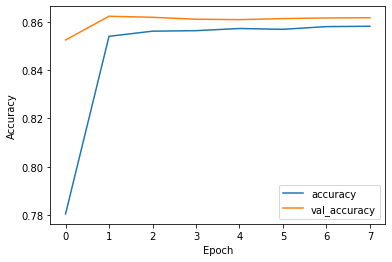

In [17]:
import matplotlib.pyplot as plt

# Plot history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

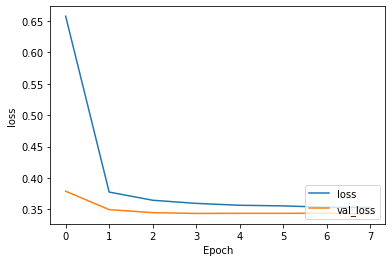

In [18]:
# Plot history
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

# Trained LSTM for event testing

In [19]:
y_pred_class = lstm_model.predict_classes(x_test, batch_size=128)

In [20]:
y_pred_ohe = np.array([[0] * len(unique_training_events) for pred_class in y_pred_class])
for idx, class_pred in enumerate(y_pred_class):
    y_pred_ohe[idx, class_pred] = 1

In [22]:
from sklearn.metrics import accuracy_score, mean_squared_error
accuracy = accuracy_score(y_test, y_pred_ohe)
accuracy

0.8448236204336825

In [25]:
y_pred = np.ravel(onehot_encoder_event.inverse_transform(y_pred_ohe))

In [26]:
df_test['predicted_next_event_lstm'] = y_pred.tolist()
df_test['predicted_next_event_lstm']

0         A_PARTLYSUBMITTED
1        W_Afhandelen leads
2                       NaN
3         A_PARTLYSUBMITTED
4        W_Afhandelen leads
                ...        
38039    W_Afhandelen leads
38040    W_Afhandelen leads
38096            A_DECLINED
38099    W_Afhandelen leads
38100                   NaN
Name: predicted_next_event_lstm, Length: 47823, dtype: object

In [79]:
accuracy

0.7906028480020074

# Trained LSTM for time testing

In [8]:
y_pred = lstm_model.predict(x_test, batch_size=64)

In [11]:
from sklearn.metrics import accuracy_score, mean_squared_error
from math import sqrt
inverse_y_test = time_to_next_scaler.inverse_transform(y_test)
inverse_y_pred = time_to_next_scaler.inverse_transform(y_pred)
rmse = sqrt(mean_squared_error(inverse_y_test, inverse_y_pred))
rmse

113119.6451562069

In [ ]:
time_to_next_scaler.inverse_transform

In [78]:
# Or visualise using Tensorboard
%tensorboard --logdir jobdir/logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8212.

In [21]:
df_training

,case concept:name,eventID,case REG_DATE,case AMOUNT_REQ,event concept:name,event lifecycle:transition,event time:timestamp,unix_abs_event_time,unix_reg_time,unix_rel_event_time,actual_time_to_next_event,naive_predicted_time_to_next_event,actual_next_event,naive_predicted_next_event,day,hour
0,173688,0,2011-10-01T00:38:44.546+02:00,20000,A_SUBMITTED,COMPLETE,01-10-2011 00:38:44.546,1.317422e+09,1.317422e+09,0.000,0.334,0.585379,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED,10,0
1,173688,1,2011-10-01T00:38:44.546+02:00,20000,A_PARTLYSUBMITTED,COMPLETE,01-10-2011 00:38:44.880,1.317422e+09,1.317422e+09,0.334,53.026,35.050805,A_PREACCEPTED,W_Afhandelen leads,10,0
2,173688,2,2011-10-01T00:38:44.546+02:00,20000,A_PREACCEPTED,COMPLETE,01-10-2011 00:39:37.906,1.317422e+09,1.317422e+09,53.360,0.969,0.503153,W_Completeren aanvraag,W_Completeren aanvraag,10,0
3,173688,3,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,SCHEDULE,01-10-2011 00:39:38.875,1.317422e+09,1.317422e+09,54.329,39427.562,60570.104101,W_Completeren aanvraag,W_Completeren aanvraag,10,0
4,173688,4,2011-10-01T00:38:44.546+02:00,20000,W_Completeren aanvraag,START,01-10-2011 11:36:46.437,1.317462e+09,1.317422e+09,39481.891,356.871,60570.104101,A_ACCEPTED,W_Completeren aanvraag,10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193362,206318,44955422687236,2012-02-03T17:07:38.334+01:00,5000,A_DECLINED,COMPLETE,03-02-2012 17:55:57.294,1.328288e+09,1.328285e+09,2898.960,3.704,1.955021,W_Afhandelen leads,W_Afhandelen leads,2,17
193363,206318,44955422687237,2012-02-03T17:07:38.334+01:00,5000,W_Afhandelen leads,COMPLETE,03-02-2012 17:56:00.998,1.328288e+09,1.328285e+09,2902.664,0.000,7928.199106,NaN,W_Afhandelen leads,2,17
193364,206321,44959717654528,2012-02-03T17:08:39.199+01:00,2000,A_SUBMITTED,COMPLETE,03-02-2012 17:08:39.200,1.328285e+09,1.328285e+09,0.000,0.259,0.585379,A_PARTLYSUBMITTED,A_PARTLYSUBMITTED,2,17
193365,206321,44959717654529,2012-02-03T17:08:39.199+01:00,2000,A_PARTLYSUBMITTED,COMPLETE,03-02-2012 17:08:39.459,1.328285e+09,1.328285e+09,0.259,39.653,35.050805,A_DECLINED,W_Afhandelen leads,2,17
